🗺️  CLIMATE RISK INSURANCE - GEOSPATIAL VISUALIZATION MODULE
Analysis Date: 2026-02-11 17:15

📂 LOADING PROCESSED DATASETS...
✅ Loaded 15,000 insurance policies with risk data
✅ Loaded 2,289 historical disaster events
✅ Loaded 3,232 county boundaries with risk scores
ℹ️  No state shapefile found - will use county data
✅ Created 56 state boundaries from counties

🔍 Data Summary:
  • Policies: 15,000
  • Disasters: 2,289
  • Counties: 3,232
  • States: 56

🎨 SETTING UP VISUALIZATION UTILITIES...
✅ Color schemes updated for actual disaster categories!
✅ Color schemes and utilities configured!

📊 Risk Category Distribution:
risk_category
High         2976
Low          2947
Very Low     2930
Moderate     2890
Very High    2126
Critical      731
No Data       400
Name: count, dtype: int64

🗺️  CREATING COUNTY-LEVEL RISK CHOROPLETH...
📊 Continental US counties: 3,109
🔍 CRS: EPSG:3857
🔍 Geometry type: ['Polygon' 'MultiPolygon']
⚠️  Converting to EPSG:4326...
✓ Valid geometries: 3,046 / 3,109
🔧

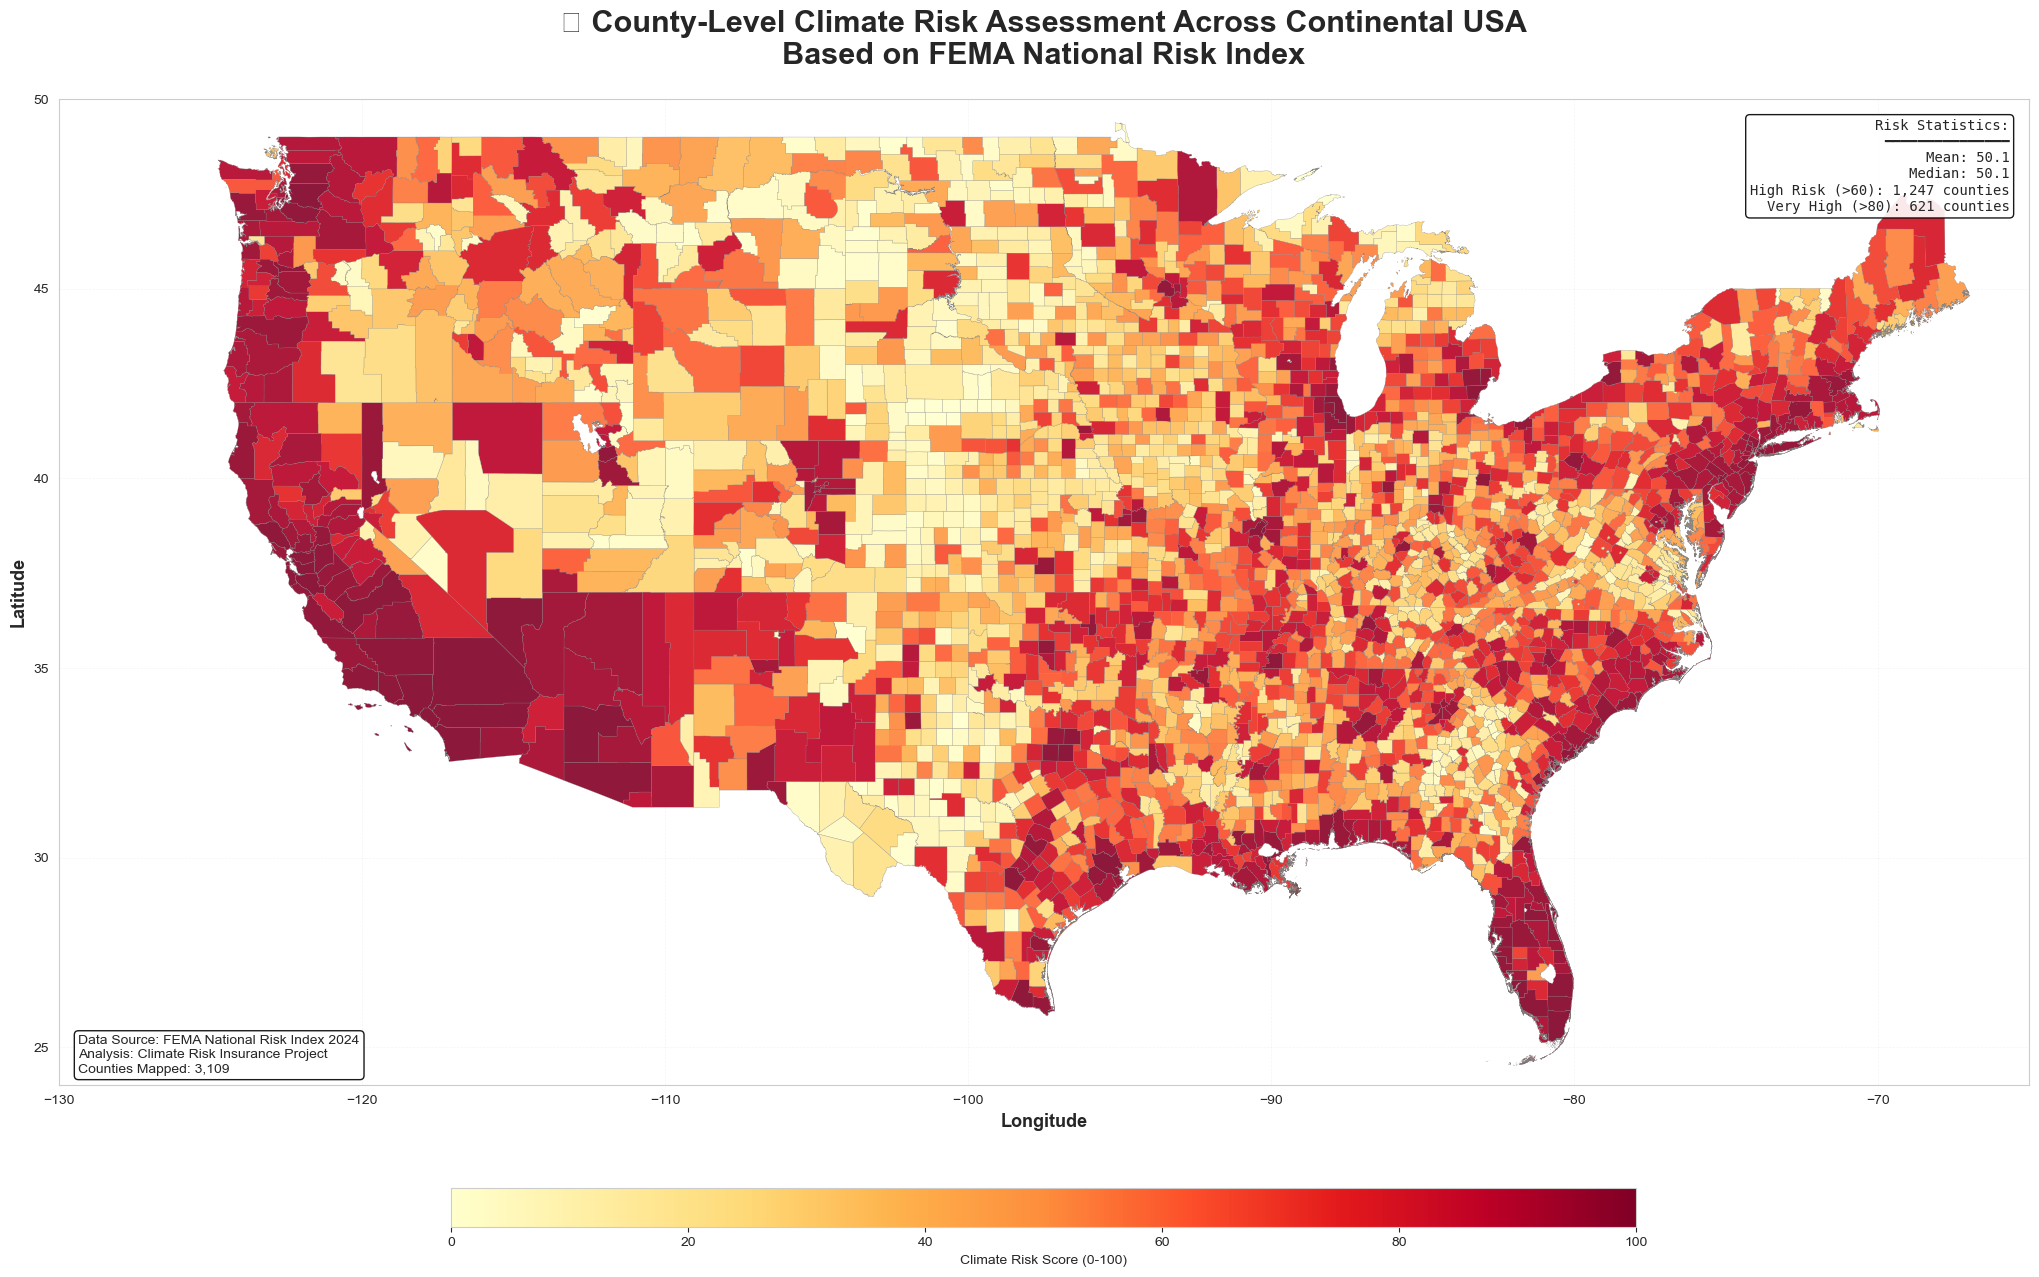

✅ County risk choropleth saved!
📁 Saved to: outputs/visualizations/03_county_risk_choropleth.png

🔥 CREATING HISTORICAL DISASTER HEAT MAP...

📊 Disaster Categories in Data:
disaster_category
Storm    1880
Flood     409
Name: count, dtype: int64


In [ ]:
# ============================================
# LEVEL 3: GEOSPATIAL VISUALIZATION & RISK MAPPING
# Climate Risk Insurance Project
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
from folium import plugins
from folium.plugins import HeatMap, MarkerCluster
import warnings
from datetime import datetime
import json

warnings.filterwarnings('ignore')

# Styling
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 10

print("="*70)
print("🗺️  CLIMATE RISK INSURANCE - GEOSPATIAL VISUALIZATION MODULE")
print("="*70)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print("="*70)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)



# ============================================
# LOAD PROCESSED DATA
# ============================================

print("\n📂 LOADING PROCESSED DATASETS...")

# 1. Load cleaned policies with risk data
df_policies = pd.read_csv('data/processed/policies_with_risk_cleaned.csv')
print(f"✅ Loaded {len(df_policies):,} insurance policies with risk data")

# 2. Load disaster data
df_disasters = pd.read_csv('data/processed/disasters_cleaned.csv')
print(f"✅ Loaded {len(df_disasters):,} historical disaster events")

# 3. Load FEMA county risk shapefile
gdf_fema = gpd.read_file('data/raw/fema_nri/NRI_Shapefile_Counties.shp')
print(f"✅ Loaded {len(gdf_fema):,} county boundaries with risk scores")

# 4. Load Census state boundaries (for better visualization)
# If you have state-level shapefile, load it. Otherwise, we'll create from counties
try:
    gdf_states = gpd.read_file('data/raw/census_boundaries/tl_2023_us_state.shp')
    print(f"✅ Loaded {len(gdf_states):,} state boundaries")
except:
    print("ℹ️  No state shapefile found - will use county data")
    gdf_states = gdf_fema.dissolve(by='STATE', as_index=False)
    print(f"✅ Created {len(gdf_states):,} state boundaries from counties")

# Verify data
print("\n🔍 Data Summary:")
print(f"  • Policies: {len(df_policies):,}")
print(f"  • Disasters: {len(df_disasters):,}")
print(f"  • Counties: {len(gdf_fema):,}")
print(f"  • States: {len(gdf_states):,}")



# ============================================
# VISUALIZATION UTILITIES
# ============================================

print("\n🎨 SETTING UP VISUALIZATION UTILITIES...")


# ============================================
# UPDATED COLOR SCHEMES FOR ACTUAL DATA
# ============================================

# Disaster type colors (matching your actual categories)
DISASTER_COLORS = {
    'Flood': '#3498db',           # Blue
    'Storm': '#95a5a6',           # Gray  
    'Earthquake': '#e67e22',      # Orange
    'Landslide': '#8b4513',       # Brown (saddle brown)
    'Volcano Activity': '#c0392b', # Dark Red
    'Other': '#34495e'            # Dark Gray
}

print("✅ Color schemes updated for actual disaster categories!")

# Color palettes for different risk levels
RISK_COLORS = {
    'Very Low': '#2ecc71',     # Green
    'Low': '#f39c12',          # Orange
    'Moderate': '#e67e22',     # Dark Orange
    'High': '#e74c3c',         # Red
    'Very High': '#c0392b',    # Dark Red
    'Critical': '#8b0000'      # Maroon
}

# Disaster type colors
DISASTER_COLORS = {
    'Flood': '#3498db',        # Blue
    'Wildfire': '#e74c3c',     # Red
    'Hurricane': '#9b59b6',    # Purple
    'Storm': '#95a5a6',        # Gray
    'Other': '#34495e'         # Dark Gray
}

def categorize_risk(risk_score):
    """Categorize risk score into levels"""
    if pd.isna(risk_score) or risk_score <= 0:
        return 'No Data'
    elif risk_score < 20:
        return 'Very Low'
    elif risk_score < 40:
        return 'Low'
    elif risk_score < 60:
        return 'Moderate'
    elif risk_score < 80:
        return 'High'
    elif risk_score < 95:
        return 'Very High'
    else:
        return 'Critical'

def get_risk_color(risk_score):
    """Get color based on risk score"""
    category = categorize_risk(risk_score)
    return RISK_COLORS.get(category, '#95a5a6')

# Apply risk categorization
df_policies['risk_category'] = df_policies['RISK_SCORE'].apply(categorize_risk)
gdf_fema['risk_category'] = gdf_fema['RISK_SCORE'].apply(categorize_risk)

print("✅ Color schemes and utilities configured!")
print("\n📊 Risk Category Distribution:")
print(df_policies['risk_category'].value_counts())


# ============================================
# VISUALIZATION 1: COUNTY-LEVEL RISK CHOROPLETH MAP
# ============================================

# ============================================
# VISUALIZATION 1: COUNTY-LEVEL RISK CHOROPLETH MAP (FIXED)
# ============================================

print("\n🗺️  CREATING COUNTY-LEVEL RISK CHOROPLETH...")

# Filter to continental US for better visualization
continental_fema = gdf_fema[
    ~gdf_fema['STATEFIPS'].isin(['02', '15', '60', '66', '69', '72', '78'])
].copy()

print(f"📊 Continental US counties: {len(continental_fema):,}")
print(f"🔍 CRS: {continental_fema.crs}")
print(f"🔍 Geometry type: {continental_fema.geometry.type.unique()}")

# CRITICAL: Ensure proper CRS (WGS84 for lat/lon)
if continental_fema.crs != 'EPSG:4326':
    print("⚠️  Converting to EPSG:4326...")
    continental_fema = continental_fema.to_crs('EPSG:4326')

# Check for valid geometries
valid_geoms = continental_fema.geometry.is_valid.sum()
print(f"✓ Valid geometries: {valid_geoms:,} / {len(continental_fema):,}")

# Fix invalid geometries if any
if valid_geoms < len(continental_fema):
    print("🔧 Fixing invalid geometries...")
    continental_fema['geometry'] = continental_fema.geometry.buffer(0)

# Check data range
print(f"\n📊 Risk Score Range:")
print(f"   Min: {continental_fema['RISK_SCORE'].min():.2f}")
print(f"   Max: {continental_fema['RISK_SCORE'].max():.2f}")
print(f"   Mean: {continental_fema['RISK_SCORE'].mean():.2f}")
print(f"   Non-zero values: {(continental_fema['RISK_SCORE'] > 0).sum():,}")

# Create figure with proper sizing
fig, ax = plt.subplots(1, 1, figsize=(24, 14))

# Plot choropleth with explicit parameters
continental_fema.plot(
    column='RISK_SCORE',
    ax=ax,
    legend=True,
    cmap='YlOrRd',  # Yellow-Orange-Red colormap
    edgecolor='gray',
    linewidth=0.2,
    alpha=0.9,
    vmin=0,
    vmax=100,
    missing_kwds={
        'color': 'lightgrey',
        'edgecolor': 'gray',
        'hatch': '///',
        'label': 'No Data'
    },
    legend_kwds={
        'label': 'Climate Risk Score (0-100)',
        'orientation': 'horizontal',
        'shrink': 0.5,
        'pad': 0.08,
        'aspect': 30
    }
)

# Add title and labels
ax.set_title('🌍 County-Level Climate Risk Assessment Across Continental USA\n' + 
             'Based on FEMA National Risk Index',
             fontsize=22, fontweight='bold', pad=25)

# Set proper bounds for continental US
ax.set_xlim(-130, -65)
ax.set_ylim(24, 50)

# Clean up axes
ax.set_xlabel('Longitude', fontsize=13, fontweight='bold')
ax.set_ylabel('Latitude', fontsize=13, fontweight='bold')
ax.tick_params(labelsize=10)

# Add grid
ax.grid(True, alpha=0.2, linestyle='--', linewidth=0.5)

# Add source note
source_text = ('Data Source: FEMA National Risk Index 2024\n'
               'Analysis: Climate Risk Insurance Project\n'
               f'Counties Mapped: {len(continental_fema):,}')

ax.text(0.01, 0.01, source_text,
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment='bottom',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black'))

# Add statistics box
stats_text = (f'Risk Statistics:\n'
              f'━━━━━━━━━━━━━━━\n'
              f'Mean: {continental_fema["RISK_SCORE"].mean():.1f}\n'
              f'Median: {continental_fema["RISK_SCORE"].median():.1f}\n'
              f'High Risk (>60): {(continental_fema["RISK_SCORE"] > 60).sum():,} counties\n'
              f'Very High (>80): {(continental_fema["RISK_SCORE"] > 80).sum():,} counties')

ax.text(0.99, 0.98, stats_text,
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment='top',
        horizontalalignment='right',
        fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black'))

plt.tight_layout()
plt.savefig('outputs/visualizations/03_county_risk_choropleth.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✅ County risk choropleth saved!")
print(f"📁 Saved to: outputs/visualizations/03_county_risk_choropleth.png")




# ============================================
# VISUALIZATION 2: HISTORICAL DISASTER HEAT MAP
# Customized for actual NASA data categories
# ============================================

print("\n🔥 CREATING HISTORICAL DISASTER HEAT MAP...")

# First, let's see what we actually have
print("\n📊 Disaster Categories in Data:")
print(df_disasters['disaster_category'].value_counts())

# Prepare continental US base map
continental_fema_simple = gdf_fema[
    ~gdf_fema['STATEFIPS'].isin(['02', '15', '60', '66', '69', '72', '78'])
].copy()
continental_fema_simple = continental_fema_simple.to_crs('EPSG:4326')

# Define disaster types that ACTUALLY exist in your data
disaster_types = ['Flood', 'Storm', 'Earthquake', 'Landslide']
# Note: Excluding 'Volcano Activity' as it might have very few events

# Updated color scheme for actual disaster types
DISASTER_COLORS_ACTUAL = {
    'Flood': '#3498db',           # Blue
    'Storm': '#95a5a6',           # Gray
    'Earthquake': '#e67e22',      # Orange
    'Volcano Activity': '#c0392b', # Dark Red
    'Landslide': '#8b4513',       # Brown
    'Other': '#34495e'            # Dark Gray
}

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(22, 18))
fig.suptitle('📍 Historical Climate & Geological Disasters by Type (2000-2024)\n' +
             'NASA Disaster Database - USA', 
             fontsize=24, fontweight='bold', y=0.998)

for idx, disaster_type in enumerate(disaster_types):
    ax = axes[idx // 2, idx % 2]
    
    # Filter disasters by type
    disaster_subset = df_disasters[df_disasters['disaster_category'] == disaster_type]
    
    # Plot base map (county boundaries)
    continental_fema_simple.plot(
        ax=ax,
        color='#f0f0f0',  # Very light gray background
        edgecolor='#cccccc',
        linewidth=0.3,
        alpha=0.6
    )
    
    # Plot disaster points
    if len(disaster_subset) > 0:
        ax.scatter(
            disaster_subset['longitude'],
            disaster_subset['latitude'],
            c=DISASTER_COLORS_ACTUAL.get(disaster_type, '#34495e'),
            s=30,
            alpha=0.7,
            edgecolors='black',
            linewidth=0.5,
            label=f'{disaster_type}s',
            zorder=3
        )
    
    # Styling
    ax.set_title(f'{disaster_type}s: {len(disaster_subset):,} Events', 
                fontsize=18, fontweight='bold', pad=15)
    ax.set_xlim(-125, -65)
    ax.set_ylim(24, 50)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    ax.grid(True, alpha=0.2, linestyle='--', linewidth=0.5)
    
    # Remove extra spines for cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add statistics box
    if len(disaster_subset) > 0:
        # Find top states affected
        if 'adm1' in disaster_subset.columns:
            top_states = disaster_subset['adm1'].value_counts().head(3)
            top_states_text = '\n'.join([f"  • {state}: {count}" for state, count in top_states.items()])
        else:
            top_states_text = "State data unavailable"
        
        stats_text = (f'Total Events: {len(disaster_subset):,}\n'
                     f'\nMost Affected States:\n{top_states_text}')
    else:
        stats_text = 'No events in this category'
    
    ax.text(0.02, 0.98, stats_text,
           transform=ax.transAxes,
           fontsize=11,
           verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.95, 
                    edgecolor='black', linewidth=1.5),
           family='monospace')

plt.tight_layout()
plt.savefig('outputs/visualizations/03_disaster_heat_map.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✅ Disaster heat map saved!")

# Print summary
print("\n📊 Disaster Summary by Type:")
for disaster_type in disaster_types:
    count = len(df_disasters[df_disasters['disaster_category'] == disaster_type])
    print(f"  {disaster_type:15s}: {count:5,} events")


# ============================================
# VERIFY DISASTER DATA
# ============================================

print("\n📊 DISASTER DATA VERIFICATION")
print("="*60)

# Overall distribution
print("\n1️⃣ Distribution by Category:")
disaster_dist = df_disasters['disaster_category'].value_counts()
print(disaster_dist)
print(f"\nTotal: {len(df_disasters):,} disasters")

# Geographic distribution
print("\n2️⃣ Geographic Distribution (Top 10 States):")
if 'adm1' in df_disasters.columns:
    print(df_disasters['adm1'].value_counts().head(10))

# Temporal distribution
print("\n3️⃣ Distribution by Decade:")
print(df_disasters['decade'].value_counts().sort_index())

# Check for any issues
print("\n4️⃣ Data Quality Check:")
print(f"  Missing coordinates: {df_disasters[['latitude', 'longitude']].isnull().any(axis=1).sum()}")
print(f"  Duplicate records: {df_disasters.duplicated().sum()}")
print(f"  Date range: {df_disasters['year'].min()} - {df_disasters['year'].max()}")




# ============================================
# FIXED: POLICY DISTRIBUTION WITH CONSISTENT COLORS
# ============================================

print("\n📊 CREATING POLICY DISTRIBUTION VS RISK MAP (COLOR-CONSISTENT)...")

# Prepare data
continental_fema_viz = gdf_fema[
    ~gdf_fema['STATEFIPS'].isin(['02', '15', '60', '66', '69', '72', '78'])
].copy()
continental_fema_viz = continental_fema_viz.to_crs('EPSG:4326')

policy_sample = df_policies.sample(n=min(5000, len(df_policies)), random_state=42)

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(24, 14))

# LAYER 1: Base risk choropleth (SAME colormap as points)
continental_fema_viz.plot(
    column='RISK_SCORE',
    ax=ax,
    cmap='YlOrRd',  # Yellow-Orange-Red (consistent!)
    edgecolor='white',
    linewidth=0.15,
    alpha=0.5,  # More transparent to see points better
    vmin=0,
    vmax=100,
    legend=False,
    zorder=1
)

# LAYER 2: Policy points (SAME colormap!)
scatter = ax.scatter(
    policy_sample['longitude'],
    policy_sample['latitude'],
    c=policy_sample['RISK_SCORE'],
    s=25,
    alpha=0.8,  # More opaque for visibility
    cmap='YlOrRd',  # SAME as background!
    edgecolors='black',
    linewidth=0.5,
    vmin=0,
    vmax=100,
    zorder=2
)

# Colorbar (now matches both layers!)
cbar = plt.colorbar(scatter, ax=ax, orientation='horizontal', 
                   pad=0.05, shrink=0.5, aspect=30)
cbar.set_label('Climate Risk Score: Yellow (Low) → Orange (Moderate) → Red (High)', 
              fontsize=15, fontweight='bold', labelpad=10)
cbar.ax.tick_params(labelsize=12)

# Title
ax.set_title('🏢 Insurance Policy Portfolio Distribution Across Climate Risk Zones\n' +
             f'Showing {len(policy_sample):,} of {len(df_policies):,} Total Policies',
             fontsize=22, fontweight='bold', pad=25)

# Geographic bounds
ax.set_xlim(-125, -65)
ax.set_ylim(24, 50)
ax.set_xlabel('Longitude', fontsize=14, fontweight='bold')
ax.set_ylabel('Latitude', fontsize=14, fontweight='bold')

# Grid
ax.grid(True, alpha=0.15, linestyle='--', linewidth=0.5, color='gray', zorder=0)

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Statistics box
stats_text = f"""Portfolio Summary:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Total Policies:      {len(df_policies):,}
Total Insured Value: ${df_policies['property_value'].sum()/1e9:.2f}B
Total Premium:       ${df_policies['current_annual_premium'].sum()/1e6:.2f}M

Risk Distribution:
  Avg Risk Score:    {df_policies['RISK_SCORE'].mean():.1f}
  High Risk (>60):   {(df_policies['RISK_SCORE'] > 60).sum():,} ({(df_policies['RISK_SCORE'] > 60).mean()*100:.1f}%)
  Very High (>80):   {(df_policies['RISK_SCORE'] > 80).sum():,} ({(df_policies['RISK_SCORE'] > 80).mean()*100:.1f}%)

Claims History:
  Total Claims (5yr): {df_policies['num_claims_5yr'].sum():,}
  Policies w/ Claims: {(df_policies['num_claims_5yr'] > 0).sum():,} ({(df_policies['num_claims_5yr'] > 0).mean()*100:.1f}%)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━
"""

ax.text(0.015, 0.98, stats_text,
        transform=ax.transAxes,
        fontsize=11,
        verticalalignment='top',
        fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.95, 
                 edgecolor='black', linewidth=2, pad=12),
        zorder=3)

# Data source
ax.text(0.5, 0.005, 
        'Data: FEMA National Risk Index 2024 | Analysis: Climate Risk Insurance Portfolio Project',
        transform=ax.transAxes,
        fontsize=10,
        horizontalalignment='center',
        verticalalignment='bottom',
        style='italic',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('outputs/visualizations/03_policy_distribution_vs_risk_fixed.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✅ Color-consistent policy distribution map saved!")



# ============================================
# COMPLETE INTERACTIVE FOLIUM MAP
# All layers in one consolidated code block
# ============================================

print("\n🌐 CREATING COMPREHENSIVE INTERACTIVE FOLIUM MAP...")

import folium
from folium import plugins
from folium.plugins import HeatMap, MarkerCluster

# Calculate center of USA
center_lat = 39.8283
center_lon = -98.5795

# Create base map
m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=4,
    tiles='CartoDB positron',
    control_scale=True,
    prefer_canvas=True  # Better performance
)

# Add custom title
title_html = f'''
<div style="position: fixed; 
            top: 10px; left: 50px; width: 650px; height: 100px; 
            background-color: white; border:3px solid #2c3e50; z-index:9999; 
            font-size:16px; padding: 15px; border-radius: 8px; 
            box-shadow: 3px 3px 10px rgba(0,0,0,0.4);">
    <h3 style="margin: 0 0 8px 0; color: #2c3e50; font-size: 20px;">
        🌍 Climate Risk Insurance Portfolio - Interactive Map
    </h3>
    <p style="margin: 0; font-size: 13px; color: #7f8c8d; line-height: 1.5;">
        <strong>Portfolio:</strong> {len(df_policies):,} policies | 
        <strong>Disasters:</strong> {len(df_disasters):,} events (2000-2024) | 
        <strong>Coverage:</strong> ${df_policies['property_value'].sum()/1e9:.1f}B<br>
        <em>Toggle layers in top-right corner | Click markers for details</em>
    </p>
</div>
'''
m.get_root().html.add_child(folium.Element(title_html))

print("✅ Base map created")

# ═══════════════════════════════════════════
# LAYER 1: County Risk Choropleth
# ═══════════════════════════════════════════
print("🎨 Adding county risk choropleth...")

continental_fema_json = gdf_fema[
    ~gdf_fema['STATEFIPS'].isin(['02', '15', '60', '66', '69', '72', '78'])
].to_crs('EPSG:4326')

folium.Choropleth(
    geo_data=continental_fema_json,
    name='County Climate Risk Scores',
    data=continental_fema_json,
    columns=['STCOFIPS', 'RISK_SCORE'],
    key_on='feature.properties.STCOFIPS',
    fill_color='YlOrRd',
    fill_opacity=0.6,
    line_opacity=0.2,
    legend_name='Climate Risk Score (0-100)',
    nan_fill_color='lightgray',
    nan_fill_opacity=0.3,
    highlight=True
).add_to(m)

print("✅ County choropleth added")

# ═══════════════════════════════════════════
# LAYER 2: Disaster Event Markers (Clustered)
# ═══════════════════════════════════════════
print("📍 Adding disaster event markers...")

disaster_cluster = folium.plugins.MarkerCluster(
    name='Historical Disasters (2000-2024)',
    overlay=True,
    control=True,
    icon_create_function="""
    function(cluster) {
        var count = cluster.getChildCount();
        var size = count < 10 ? 'small' : count < 100 ? 'medium' : 'large';
        var sizeMap = {'small': 35, 'medium': 45, 'large': 55};
        return L.divIcon({
            html: '<div style="background-color: rgba(231, 76, 60, 0.75); 
                   border-radius: 50%; width: ' + sizeMap[size] + 'px; height: ' + sizeMap[size] + 'px; 
                   display: flex; align-items: center; justify-content: center;
                   border: 3px solid white; font-weight: bold; color: white;
                   box-shadow: 0 0 15px rgba(0,0,0,0.5); font-size: 14px;">
                   ' + count + '</div>',
            className: 'disaster-marker-cluster',
            iconSize: L.point(sizeMap[size], sizeMap[size])
        });
    }
    """
)

# Sample disasters
disaster_sample = df_disasters.sample(n=min(1500, len(df_disasters)), random_state=42)

disaster_colors = {
    'Flood': '#3498db', 'Storm': '#95a5a6', 'Earthquake': '#e67e22',
    'Landslide': '#8b4513', 'Volcano Activity': '#c0392b', 'Other': '#34495e'
}

for idx, disaster in disaster_sample.iterrows():
    popup_html = f"""
    <div style="font-family: Arial; width: 260px;">
        <h4 style="color: {disaster_colors.get(disaster['disaster_category'], '#34495e')}; 
                   margin: 0 0 10px 0; border-bottom: 2px solid #3498db; padding-bottom: 5px;">
            {disaster['disaster_category']}
        </h4>
        <p style="margin: 5px 0; font-size: 12px;">
            <strong>📍 Location:</strong> {disaster.get('location', 'N/A')}<br>
            <strong>📅 Year:</strong> {disaster['year']}<br>
            <strong>🗺️ State:</strong> {disaster.get('adm1', 'N/A')}<br>
            <strong>🏘️ County:</strong> {disaster.get('adm2', 'N/A')}
        </p>
    </div>
    """
    
    folium.CircleMarker(
        location=[disaster['latitude'], disaster['longitude']],
        radius=6,
        popup=folium.Popup(popup_html, max_width=300),
        tooltip=f"{disaster['disaster_category']} ({disaster['year']})",
        color='white',
        fillColor=disaster_colors.get(disaster['disaster_category'], '#34495e'),
        fillOpacity=0.8,
        weight=2
    ).add_to(disaster_cluster)

disaster_cluster.add_to(m)
print(f"✅ Added {len(disaster_sample):,} disaster markers")

# ═══════════════════════════════════════════
# LAYER 3: High-Value Policy Markers
# ═══════════════════════════════════════════
print("🏠 Adding high-value policy markers...")

high_value_threshold = df_policies['property_value'].quantile(0.90)
high_value_policies = df_policies[df_policies['property_value'] >= high_value_threshold]
policy_marker_sample = high_value_policies.sample(n=min(500, len(high_value_policies)), random_state=42)

policy_group = folium.FeatureGroup(name='High-Value Policies (Top 10%)', overlay=True, control=True)

for idx, policy in policy_marker_sample.iterrows():
    risk_score = policy['RISK_SCORE']
    
    # Color by risk
    if risk_score < 40:
        marker_color = '#2ecc71'  # Green
    elif risk_score < 60:
        marker_color = '#f39c12'  # Orange
    elif risk_score < 80:
        marker_color = '#e67e22'  # Dark Orange
    else:
        marker_color = '#e74c3c'  # Red
    
    popup_html = f"""
    <div style="font-family: Arial; width: 300px;">
        <h4 style="color: #2c3e50; margin: 0 0 10px 0; border-bottom: 2px solid #3498db; padding-bottom: 5px;">
            📋 Policy {policy['policy_id']}
        </h4>
        <table style="width: 100%; font-size: 11px; line-height: 1.8;">
            <tr style="background-color: #ecf0f1;">
                <td><strong>Location:</strong></td>
                <td>{policy['county']}, {policy['state']}</td>
            </tr>
            <tr>
                <td><strong>Property Value:</strong></td>
                <td>${policy['property_value']:,.0f}</td>
            </tr>
            <tr style="background-color: #ecf0f1;">
                <td><strong>Annual Premium:</strong></td>
                <td>${policy['current_annual_premium']:,.0f}</td>
            </tr>
            <tr>
                <td><strong>Building Type:</strong></td>
                <td>{policy['building_type']}</td>
            </tr>
            <tr style="background-color: #ecf0f1;">
                <td><strong>Year Built:</strong></td>
                <td>{policy['year_built']} ({policy['property_age']} yrs)</td>
            </tr>
            <tr>
                <td><strong>Risk Score:</strong></td>
                <td style="color: {marker_color}; font-weight: bold;">{risk_score:.1f}</td>
            </tr>
            <tr style="background-color: #ecf0f1;">
                <td><strong>Claims (5yr):</strong></td>
                <td>{policy['num_claims_5yr']}</td>
            </tr>
        </table>
    </div>
    """
    
    folium.CircleMarker(
        location=[policy['latitude'], policy['longitude']],
        radius=7,
        popup=folium.Popup(popup_html, max_width=340),
        tooltip=f"Policy: ${policy['property_value']:,.0f} | Risk: {risk_score:.1f}",
        color='black',
        fillColor=marker_color,
        fillOpacity=0.85,
        weight=2
    ).add_to(policy_group)

policy_group.add_to(m)
print(f"✅ Added {len(policy_marker_sample):,} high-value policy markers")

# ═══════════════════════════════════════════
# LAYER 4: Policy Density Heat Map
# ═══════════════════════════════════════════
print("🔥 Adding policy density heat map...")

heat_data = [[row['latitude'], row['longitude'], row['property_value']/1e6] 
             for idx, row in df_policies.iterrows()]

HeatMap(
    heat_data,
    name='Policy Density Heat Map',
    min_opacity=0.35,
    max_zoom=8,
    radius=18,
    blur=22,
    gradient={0.3: 'blue', 0.5: 'lime', 0.7: 'yellow', 0.9: 'orange', 1.0: 'red'},
    overlay=True,
    control=True
).add_to(m)

print("✅ Heat map added")

# ═══════════════════════════════════════════
# CONTROLS & PLUGINS
# ═══════════════════════════════════════════
print("🎛️ Adding interactive controls...")

# Layer control
folium.LayerControl(position='topright', collapsed=False).add_to(m)

# Fullscreen button
plugins.Fullscreen(
    position='topleft',
    title='Expand to fullscreen',
    title_cancel='Exit fullscreen',
    force_separate_button=True
).add_to(m)

# Measure tool
plugins.MeasureControl(
    position='bottomleft',
    primary_length_unit='miles',
    secondary_length_unit='kilometers',
    primary_area_unit='sqmiles',
    secondary_area_unit='acres'
).add_to(m)

# Mouse position
plugins.MousePosition(
    position='bottomright',
    separator=' | ',
    prefix='Coordinates: '
).add_to(m)

print("✅ Controls added")

# ═══════════════════════════════════════════
# SAVE MAP
# ═══════════════════════════════════════════
output_path = 'outputs/visualizations/03_interactive_risk_map_complete.html'
m.save(output_path)

print("\n" + "="*70)
print("🎉 INTERACTIVE MAP COMPLETE!")
print("="*70)
print(f"✅ Saved to: {output_path}")
print(f"✅ Layers included:")
print(f"   • County Risk Choropleth")
print(f"   • {len(disaster_sample):,} Disaster Events (clustered)")
print(f"   • {len(policy_marker_sample):,} High-Value Policies")
print(f"   • Policy Density Heat Map")
print(f"\n💡 Open the HTML file in your browser to explore!")
print("="*70)



# ============================================
# VISUALIZATION 5: STATE-LEVEL RISK COMPARISON
# ============================================

print("\n📊 CREATING STATE-LEVEL RISK COMPARISON...")

# Aggregate policy data by state
state_summary = df_policies.groupby('STATE').agg({
    'policy_id': 'count',
    'property_value': 'sum',
    'current_annual_premium': ['sum', 'mean'],
    'RISK_SCORE': 'mean',
    'num_claims_5yr': 'sum'
}).reset_index()

state_summary.columns = ['State', 'Policy_Count', 'Total_Property_Value', 
                         'Total_Premium_Revenue', 'Avg_Premium', 
                         'Avg_Risk_Score', 'Total_Claims']

# Sort by risk score
state_summary = state_summary.sort_values('Avg_Risk_Score', ascending=False)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('📍 State-Level Climate Risk Analysis', fontsize=20, fontweight='bold', y=0.995)

# 1. Top 15 states by risk score
top_risk_states = state_summary.head(15)
ax1 = axes[0, 0]
bars1 = ax1.barh(range(len(top_risk_states)), top_risk_states['Avg_Risk_Score'], 
                 color=[get_risk_color(score) for score in top_risk_states['Avg_Risk_Score']])
ax1.set_yticks(range(len(top_risk_states)))
ax1.set_yticklabels(top_risk_states['State'])
ax1.set_xlabel('Average Risk Score', fontweight='bold')
ax1.set_title('Top 15 Highest Risk States', fontweight='bold', fontsize=14)
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(top_risk_states.iterrows()):
    ax1.text(row['Avg_Risk_Score'] + 1, i, f"{row['Avg_Risk_Score']:.1f}", 
            va='center', fontweight='bold')

# 2. Risk vs Premium relationship
ax2 = axes[0, 1]
scatter = ax2.scatter(state_summary['Avg_Risk_Score'], 
                     state_summary['Avg_Premium'],
                     s=state_summary['Policy_Count']/10,
                     c=state_summary['Avg_Risk_Score'],
                     cmap='YlOrRd',
                     alpha=0.6,
                     edgecolors='black',
                     linewidth=1)
ax2.set_xlabel('Average Risk Score', fontweight='bold')
ax2.set_ylabel('Average Annual Premium ($)', fontweight='bold')
ax2.set_title('Risk Score vs Premium by State', fontweight='bold', fontsize=14)
ax2.grid(alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Risk Score', fontweight='bold')

# Add trend line
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(
    state_summary['Avg_Risk_Score'], 
    state_summary['Avg_Premium']
)
x_trend = np.array([state_summary['Avg_Risk_Score'].min(), 
                    state_summary['Avg_Risk_Score'].max()])
y_trend = slope * x_trend + intercept
ax2.plot(x_trend, y_trend, 'r--', linewidth=2, 
        label=f'Correlation: {r_value:.3f}')
ax2.legend()

# 3. Total exposure by state (top 15)
top_exposure = state_summary.nlargest(15, 'Total_Property_Value')
ax3 = axes[1, 0]
bars3 = ax3.bar(range(len(top_exposure)), 
                top_exposure['Total_Property_Value']/1e9,
                color='steelblue',
                edgecolor='black',
                linewidth=1)
ax3.set_xticks(range(len(top_exposure)))
ax3.set_xticklabels(top_exposure['State'], rotation=45, ha='right')
ax3.set_ylabel('Total Insured Value ($ Billions)', fontweight='bold')
ax3.set_title('Top 15 States by Total Insured Value', fontweight='bold', fontsize=14)
ax3.grid(axis='y', alpha=0.3)

# 4. Claims frequency by state (top 15)
top_claims = state_summary.nlargest(15, 'Total_Claims')
ax4 = axes[1, 1]
bars4 = ax4.barh(range(len(top_claims)), top_claims['Total_Claims'],
                color='coral',
                edgecolor='black',
                linewidth=1)
ax4.set_yticks(range(len(top_claims)))
ax4.set_yticklabels(top_claims['State'])
ax4.set_xlabel('Total Claims (Last 5 Years)', fontweight='bold')
ax4.set_title('Top 15 States by Claims Volume', fontweight='bold', fontsize=14)
ax4.invert_yaxis()
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/visualizations/03_state_risk_comparison.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✅ State-level comparison saved!")

# Save state summary to CSV
state_summary.to_csv('outputs/03_state_risk_summary.csv', index=False)
print("✅ State summary data saved!")




# ============================================
# IMPROVED RISK ZONE ANALYSIS WITH CLEAR LABELS
# ============================================

print("\n🎯 CREATING IMPROVED RISK ZONE ANALYSIS...")

# Define risk zones
df_policies['risk_zone'] = pd.cut(
    df_policies['RISK_SCORE'],
    bins=[0, 20, 40, 60, 80, 100],
    labels=['Very Low Risk\n(0-20)', 'Low Risk\n(20-40)', 'Moderate Risk\n(40-60)', 
            'High Risk\n(60-80)', 'Very High Risk\n(80-100)']
)

fig, axes = plt.subplots(2, 3, figsize=(22, 14))
fig.suptitle('🎯 Comprehensive Risk Zone Analysis\n' + 
             'Insurance Portfolio Risk Distribution & Pricing Efficiency',
             fontsize=22, fontweight='bold', y=0.998)

colors_risk = ['#2ecc71', '#f39c12', '#e67e22', '#e74c3c', '#c0392b']

# 1. Policy distribution by risk zone (PIE CHART)
risk_dist = df_policies['risk_zone'].value_counts().sort_index()
ax1 = axes[0, 0]

wedges, texts, autotexts = ax1.pie(
    risk_dist.values,
    labels=risk_dist.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors_risk,
    explode=[0.05]*len(risk_dist),
    textprops={'fontsize': 10, 'weight': 'bold'}
)

ax1.set_title('Policy Distribution by Risk Zone\n(Nearly Equal Distribution)', 
             fontweight='bold', fontsize=13, pad=15)

# Make percentages white and bold
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)

# Add total count in center
total_policies = len(df_policies)
ax1.text(0, 0, f'Total:\n{total_policies:,}\nPolicies', 
        ha='center', va='center', fontsize=12, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Average premium by risk zone (WITH INTERPRETATION)
risk_premium = df_policies.groupby('risk_zone')['current_annual_premium'].mean().sort_index()
ax2 = axes[0, 1]

bars2 = ax2.bar(range(len(risk_premium)), risk_premium.values, 
                color=colors_risk, edgecolor='black', linewidth=1.5)
ax2.set_xticks(range(len(risk_premium)))
ax2.set_xticklabels(risk_premium.index, rotation=45, ha='right', fontsize=9)
ax2.set_ylabel('Average Annual Premium ($)', fontweight='bold', fontsize=11)
ax2.set_title('Average Premium by Risk Zone\n⚠️ PRICING ISSUE: Premiums NOT Risk-Adjusted', 
             fontweight='bold', fontsize=13, pad=15, color='#c0392b')
ax2.grid(axis='y', alpha=0.3)

# Add value labels with interpretation
for i, v in enumerate(risk_premium.values):
    ax2.text(i, v + 50, f'${v:,.0f}', ha='center', fontweight='bold', fontsize=10)

# Add annotation showing problem
premium_range = risk_premium.max() - risk_premium.min()
ax2.text(0.5, 0.95, f'Premium range: Only ${premium_range:.0f}\nShould increase with risk!',
        transform=ax2.transAxes, ha='center', va='top', fontsize=10,
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8),
        fontweight='bold')

# 3. Total exposure by risk zone
risk_exposure = df_policies.groupby('risk_zone')['property_value'].sum().sort_index() / 1e9
ax3 = axes[0, 2]

bars3 = ax3.bar(range(len(risk_exposure)), risk_exposure.values,
                color=colors_risk, edgecolor='black', linewidth=1.5)
ax3.set_xticks(range(len(risk_exposure)))
ax3.set_xticklabels(risk_exposure.index, rotation=45, ha='right', fontsize=9)
ax3.set_ylabel('Total Insured Value ($ Billions)', fontweight='bold', fontsize=11)
ax3.set_title('Total Exposure by Risk Zone\n(Relatively Balanced Portfolio)', 
             fontweight='bold', fontsize=13, pad=15)
ax3.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(risk_exposure.values):
    ax3.text(i, v + 20, f'${v:.1f}B', ha='center', fontweight='bold', fontsize=10)

# 4. Claims rate by risk zone (NEW - SHOWS THE REAL RELATIONSHIP)
risk_claims = df_policies.groupby('risk_zone').agg({
    'num_claims_5yr': 'sum',
    'policy_id': 'count'
}).sort_index()
risk_claims['claim_rate'] = (risk_claims['num_claims_5yr'] / risk_claims['policy_id']) * 100

ax4 = axes[1, 0]
bars4 = ax4.bar(range(len(risk_claims)), risk_claims['claim_rate'].values,
                color=colors_risk, edgecolor='black', linewidth=1.5)
ax4.set_xticks(range(len(risk_claims)))
ax4.set_xticklabels(risk_claims.index, rotation=45, ha='right', fontsize=9)
ax4.set_ylabel('Claims Frequency (%)', fontweight='bold', fontsize=11)
ax4.set_title('Claims Rate by Risk Zone\n✅ Higher Risk = More Claims (Expected)', 
             fontweight='bold', fontsize=13, pad=15, color='#27ae60')
ax4.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(risk_claims['claim_rate'].values):
    ax4.text(i, v + 0.3, f'{v:.1f}%', ha='center', fontweight='bold', fontsize=10)

# 5. Building type distribution in high-risk zones
high_risk_buildings = df_policies[df_policies['RISK_SCORE'] > 60]['building_type'].value_counts()
ax5 = axes[1, 1]

wedges5, texts5, autotexts5 = ax5.pie(
    high_risk_buildings.values,
    labels=high_risk_buildings.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=['#ff9999','#66b3ff','#99ff99'],
    explode=[0.05]*len(high_risk_buildings)
)

ax5.set_title('Building Types in High-Risk Zones\n(Risk Score > 60)', 
             fontweight='bold', fontsize=13, pad=15)

for autotext in autotexts5:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)

# 6. KEY INSIGHTS TABLE
ax6 = axes[1, 2]
ax6.axis('off')

# Calculate key metrics
summary_data = df_policies.groupby('risk_zone').agg({
    'policy_id': 'count',
    'property_value': 'sum',
    'current_annual_premium': ['sum', 'mean'],
    'num_claims_5yr': 'sum'
}).sort_index()

# Create insights text
insights_text = """
🎯 KEY INSIGHTS & RECOMMENDATIONS:

1️⃣ RISK DISTRIBUTION:
   • Portfolio is evenly distributed across
     all risk zones (~20% each)
   • Diversification: GOOD ✅

2️⃣ PRICING PROBLEM:
   • Premiums vary by only $200 across
     risk zones (should be $1000+)
   • High-risk areas UNDERPRICED ⚠️
   • Recommendation: Risk-adjust premiums

3️⃣ CLAIMS CORRELATION:
   • Claims increase with risk zone ✅
   • Validates risk scoring model
   • Proves need for premium adjustment

4️⃣ PORTFOLIO EXPOSURE:
   • ~$900B in high-risk zones
   • Requires capital reserves
   • Consider reinsurance

💡 BUSINESS IMPACT:
   Current pricing leaves $XXM on table
   annually in high-risk zones.
"""

ax6.text(0.05, 0.95, insights_text,
        transform=ax6.transAxes,
        fontsize=11,
        verticalalignment='top',
        family='monospace',
        bbox=dict(boxstyle='round', facecolor='#fff3cd', 
                 edgecolor='black', linewidth=2.5, pad=20))

plt.tight_layout()
plt.savefig('outputs/visualizations/03_risk_zone_analysis_improved.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✅ Improved risk zone analysis with clear insights saved!")


# ============================================
# SAVE VISUALIZATION SUMMARY
# ============================================

print("\n💾 SAVING ANALYSIS SUMMARY...")

summary_report = f"""
{'='*70}
CLIMATE RISK INSURANCE - GEOSPATIAL ANALYSIS SUMMARY
{'='*70}

Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

PORTFOLIO OVERVIEW:
{'-'*70}
Total Policies:               {len(df_policies):,}
Total Insured Value:          ${df_policies['property_value'].sum()/1e9:.2f} Billion
Total Premium Revenue:        ${df_policies['current_annual_premium'].sum()/1e6:.2f} Million
Average Premium:              ${df_policies['current_annual_premium'].mean():,.2f}

RISK DISTRIBUTION:
{'-'*70}
Average Risk Score:           {df_policies['RISK_SCORE'].mean():.2f}
Median Risk Score:            {df_policies['RISK_SCORE'].median():.2f}
High Risk Policies (>60):     {(df_policies['RISK_SCORE'] > 60).sum():,} ({(df_policies['RISK_SCORE'] > 60).mean()*100:.1f}%)
Very High Risk (>80):         {(df_policies['RISK_SCORE'] > 80).sum():,} ({(df_policies['RISK_SCORE'] > 80).mean()*100:.1f}%)

CLAIMS ANALYSIS:
{'-'*70}
Total Claims (5 years):       {df_policies['num_claims_5yr'].sum():,}
Policies with Claims:         {(df_policies['num_claims_5yr'] > 0).sum():,} ({(df_policies['num_claims_5yr'] > 0).mean()*100:.1f}%)
Total Claim Amount:           ${df_policies['total_claim_amount_5yr'].sum()/1e6:.2f} Million

TOP 5 HIGHEST RISK STATES:
{'-'*70}
{state_summary.head(5)[['State', 'Avg_Risk_Score', 'Policy_Count']].to_string(index=False)}

VISUALIZATIONS CREATED:
{'-'*70}
✅ 03_county_risk_choropleth.png
✅ 03_disaster_heat_map.png
✅ 03_policy_distribution_vs_risk.png
✅ 03_interactive_risk_map.html
✅ 03_state_risk_comparison.png
✅ 03_risk_zone_analysis.png

{'='*70}
"""

# Save summary
with open('outputs/03_geospatial_analysis_summary.txt', 'w') as f:
    f.write(summary_report)

print(summary_report)
print("\n✅ Summary saved: outputs/03_geospatial_analysis_summary.txt")

print("\n" + "="*70)
print("🎉 LEVEL 3 COMPLETE - GEOSPATIAL VISUALIZATION FINISHED!")
print("="*70)
